## **Step 1: Loading and Processing the Data**

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# Path to dataset
dataset_path = "fashion"

# Get list of categories
categories = os.listdir(dataset_path)
print("Categories:", categories)

# Prepare storage for images and labels
image_data = []
labels = []

# Set image size for consistency
image_size = (48, 48)

Categories: ['ankleboot', 'bag', 'coat', 'dress', 'pullover', 'sandal', 'shirt', 'sneaker', 'trouser', 'tshirt-top']


In [4]:
# Load images and store first 5 images for visualization
sample_images = {category: [] for category in categories}

for label, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    # Track number of images processed per category
    count = 0 
    
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)

        # Open, resize, and convert image to grayscale
        img = Image.open(image_path).convert("L")
        img = img.resize(image_size)
        # Flatten image into 1D array
        img_array = np.array(img).flatten()  

        # Store the image data and corresponding label
        image_data.append(img_array)
        labels.append(label)

        # Store sample images (only first 5 per category)
        if count < 5:
            sample_images[category].append(np.array(img))  # Store raw image for display
            count += 1

In [5]:
# Convert to NumPy arrays
X = np.array(image_data)
y = np.array(labels)

# Tests
print(f"Number of images and pixel size: {X.shape}")
print(f"Number of labels: {y.shape}")
print(f"Number of catagories: {len(categories)}")

Number of images and pixel size: (70000, 2304)
Number of labels: (70000,)
Number of catagories: 10


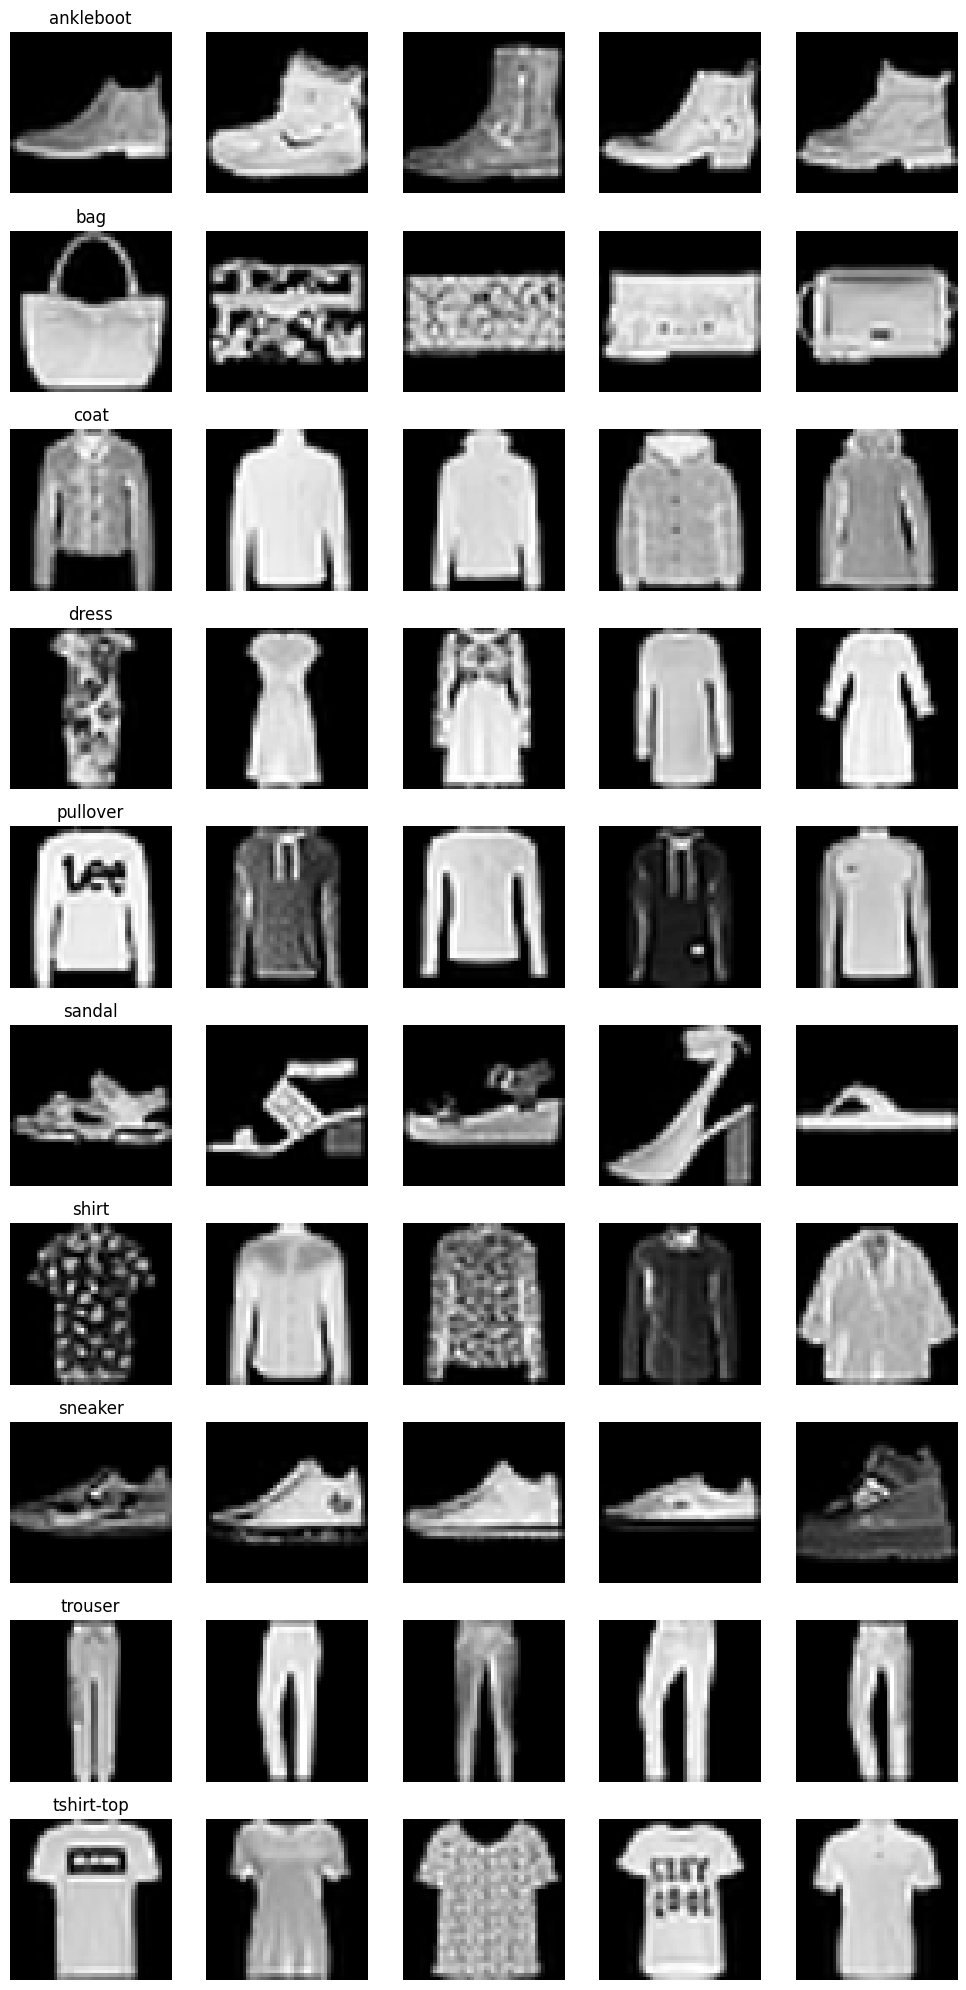

In [6]:
# Display sample images (5 per category)
fig, axes = plt.subplots(len(categories), 5, figsize=(10, len(categories) * 2))

for row, category in enumerate(categories):
    for col in range(5):
        if col < len(sample_images[category]):
            axes[row, col].imshow(sample_images[category][col], cmap="gray")
            axes[row, col].axis("off")
            axes[row, col].set_title(category if col == 0 else "")

plt.tight_layout()
plt.show()

## **Step 2: Normalising the Data**

In [7]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [8]:
# Normalise pixel values to range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
print(f"Min pixel value after scaling: {X.min()}")
print(f"Max pixel value after scaling: {X.max()}")
print(f"Min pixel value after scaling: {X_scaled.min()}")
print(f"Max pixel value after scaling: {X_scaled.max()}")
print("Data normalized successfully!")

Min pixel value after scaling: 0
Max pixel value after scaling: 255
Min pixel value after scaling: 0.0
Max pixel value after scaling: 1.0
Data normalized successfully!


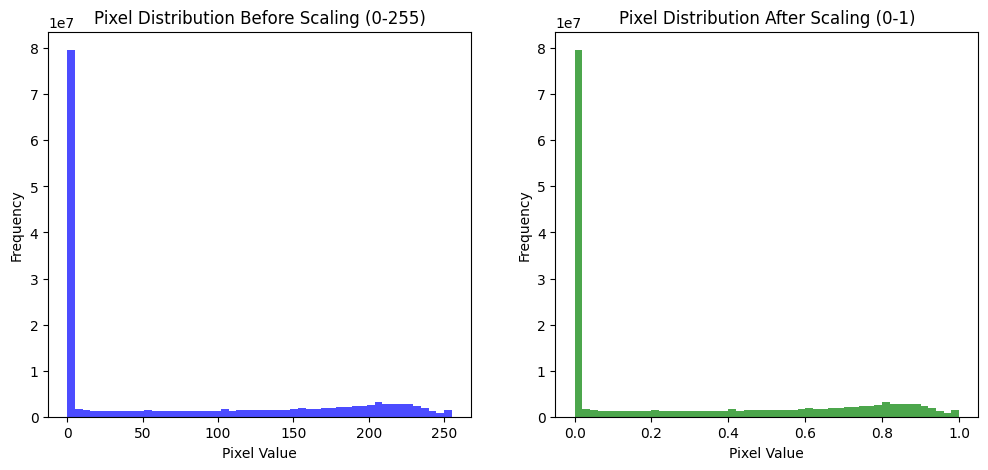

In [10]:
plt.figure(figsize=(12, 5))

# Histogram before scaling
plt.subplot(1, 2, 1)
plt.hist(X.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Pixel Distribution Before Scaling (0-255)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

# Histogram after scaling
plt.subplot(1, 2, 2)
plt.hist(X_scaled.flatten(), bins=50, color='green', alpha=0.7)
plt.title("Pixel Distribution After Scaling (0-1)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.show()


## **Step 4. Spliting Data into Training and Testing Sets**

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [12]:
# Split data for SVM
student_id = 409920
np.random.seed(student_id)

X_train_svm, X_other_svm, y_train_svm, y_other_svm = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=student_id
)
X_valid_svm, X_test_svm, y_valid_svm, y_test_svm = train_test_split(
    X_other_svm, y_other_svm, test_size=0.5, stratify=y_other_svm, random_state=student_id
)


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform valid/test
X_valid_pca = pca.transform(scaler.transform(X_valid_svm))
X_test_pca  = pca.transform(scaler.transform(X_test_svm))

In [14]:
# Use Student ID G00409920 (without G and leading 0s) as random seed
student_id = 409920
np.random.seed(student_id)

# Split dataset into train (70%) and other (30%)
X_train, X_other, y_train, y_other = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=student_id
)

In [15]:
# Fit PCA **only on training data**
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)

# Transform the remaining dataset
X_other_pca = pca.transform(X_other)

In [16]:
# Split other into validation (15%) and test (15%)
X_valid_pca, X_test_pca, y_valid, y_test = train_test_split(
    X_other_pca, y_other, test_size=0.5, stratify=y_other, random_state=student_id
)

# Print number of components retained
print(f"Number of PCA components retained: {pca.n_components_}")

Number of PCA components retained: 135


In [17]:
# Print the dataset sizes after PCA transformation
print(f"Training set: {X_train_pca.shape[0]} samples, {X_train_pca.shape[1]} PCA components")
print(f"Validation set: {X_valid_pca.shape[0]} samples, {X_valid_pca.shape[1]} PCA components")
print(f"Test set: {X_test_pca.shape[0]} samples, {X_test_pca.shape[1]} PCA components")


Training set: 49000 samples, 135 PCA components
Validation set: 10500 samples, 135 PCA components
Test set: 10500 samples, 135 PCA components


## **Step 5: Training the Models**

### Training and Evaluating SVM

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import itertools

In [25]:
# Param grid for manual looping
param_grid = {
    "kernel": ["linear", "rbf"],
    "C": [0.1, 1, 10],  
    "gamma": [0.1, 0.01]
}

cv = KFold(n_splits=5, shuffle=True, random_state=student_id)

best_combo = None
best_mean_acc = 0.0

# Create combinations but only use gamma for rbf
all_combos = [
    (kernel, c, gamma) 
    for kernel in param_grid["kernel"]
    for c in param_grid["C"]
    for gamma in (param_grid["gamma"] if kernel == "rbf" else [None])  # Skip gamma for 'linear'
]

for kernel_type, c_val, gamma_val in all_combos:
    svm_model = SVC(
        kernel=kernel_type,
        C=c_val,
        gamma=gamma_val if kernel_type == "rbf" else "auto",  # Gamma is unused for 'linear'
        class_weight="balanced",
        random_state=student_id
    )
    
    # 5-fold CV on your already PCA-transformed training set
    scores = cross_val_score(svm_model, X_train_pca, y_train_svm, cv=cv, n_jobs=-1)
    mean_acc = scores.mean()
    std_acc = scores.std()
    
    print(f"Kernel='{kernel_type}', C={c_val}, gamma={gamma_val}")
    print(f"  Fold Accuracies = {scores}")
    print(f"  Mean = {mean_acc:.4f} ± {std_acc:.4f}\n")
    
    # Track the best combo
    if mean_acc > best_mean_acc:
        best_mean_acc = mean_acc
        best_combo = (kernel_type, c_val, gamma_val)

print(f"Best combo: kernel='{best_combo[0]}', C={best_combo[1]}, gamma={best_combo[2]} (Mean CV={best_mean_acc:.4f})")


Kernel='linear', C=0.1, gamma=None
  Fold Accuracies = [0.85938776 0.86612245 0.8555102  0.8594898  0.86459184]
  Mean = 0.8610 ± 0.0039

Kernel='linear', C=1, gamma=None
  Fold Accuracies = [0.85887755 0.86642857 0.85316327 0.85826531 0.86255102]
  Mean = 0.8599 ± 0.0044

Kernel='linear', C=10, gamma=None
  Fold Accuracies = [0.85571429 0.86408163 0.85285714 0.85714286 0.86112245]
  Mean = 0.8582 ± 0.0040

Kernel='rbf', C=0.1, gamma=0.1
  Fold Accuracies = [0.36336735 0.38244898 0.36734694 0.36877551 0.37255102]
  Mean = 0.3709 ± 0.0065

Kernel='rbf', C=0.1, gamma=0.01
  Fold Accuracies = [0.85438776 0.86091837 0.85489796 0.86183673 0.85744898]
  Mean = 0.8579 ± 0.0030

Kernel='rbf', C=1, gamma=0.1
  Fold Accuracies = [0.73877551 0.75040816 0.73969388 0.74683673 0.74438776]
  Mean = 0.7440 ± 0.0044

Kernel='rbf', C=1, gamma=0.01
  Fold Accuracies = [0.89336735 0.89418367 0.88765306 0.89959184 0.89397959]
  Mean = 0.8938 ± 0.0038

Kernel='rbf', C=10, gamma=0.1
  Fold Accuracies = [0.75

In [26]:
best_kernel, best_c, best_gamma = best_combo

final_svm = SVC(
    kernel=best_kernel, 
    C=best_c, 
    gamma=best_gamma, 
    class_weight="balanced", 
    random_state=student_id
)
final_svm.fit(X_train_pca, y_train_svm)

val_acc = final_svm.score(X_valid_pca, y_valid_svm)

print(f"Final Model (kernel='{best_kernel}', C={best_c}, gamma={best_gamma})")
print(f"Validation Accuracy: {val_acc:.4f}")



Final Model (kernel='rbf', C=10, gamma=0.01)
Validation Accuracy: 0.9066


In [29]:
test_acc = final_svm.score(X_test_pca, y_test_svm)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9072


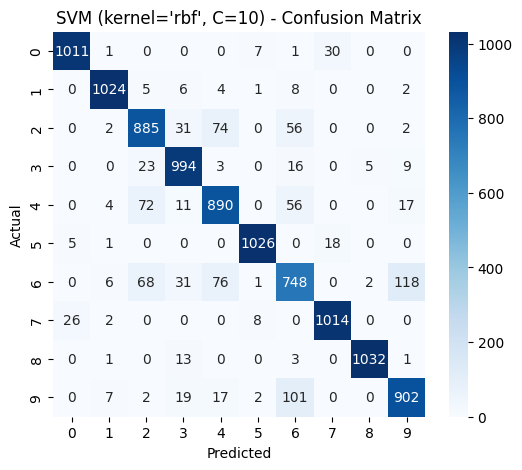

In [30]:
# Compute Confusion Matrix
y_test_pred = final_svm.predict(X_test_pca)

cm = confusion_matrix(y_test_svm, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"SVM (kernel='{best_kernel}', C={best_c}) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [31]:
# Print Classification Report
print("SVM Classification Report:")
print(classification_report(y_test_svm, y_test_pred))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1050
           1       0.98      0.98      0.98      1050
           2       0.84      0.84      0.84      1050
           3       0.90      0.95      0.92      1050
           4       0.84      0.85      0.84      1050
           5       0.98      0.98      0.98      1050
           6       0.76      0.71      0.73      1050
           7       0.95      0.97      0.96      1050
           8       0.99      0.98      0.99      1050
           9       0.86      0.86      0.86      1050

    accuracy                           0.91     10500
   macro avg       0.91      0.91      0.91     10500
weighted avg       0.91      0.91      0.91     10500



### Training and Evaluating KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [26]:
# Define K-Fold with shuffling
cv = KFold(n_splits=5, shuffle=True, random_state=student_id)

# Define range of k values to test
k_values = list(range(1, 16))

# Store mean accuracy for each k
mean_accuracies = []

# Perform 5-fold cross-validation for each k
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train_pca, y_train, cv=cv)
    mean_accuracy = scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"k={k}, Mean Accuracy: {mean_accuracy:.4f}")

k=1, Mean Accuracy: 0.8476
k=2, Mean Accuracy: 0.8409
k=3, Mean Accuracy: 0.8543
k=4, Mean Accuracy: 0.8548
k=5, Mean Accuracy: 0.8589
k=6, Mean Accuracy: 0.8582
k=7, Mean Accuracy: 0.8586
k=8, Mean Accuracy: 0.8572
k=9, Mean Accuracy: 0.8580
k=10, Mean Accuracy: 0.8579
k=11, Mean Accuracy: 0.8577
k=12, Mean Accuracy: 0.8567
k=13, Mean Accuracy: 0.8556
k=14, Mean Accuracy: 0.8554
k=15, Mean Accuracy: 0.8541


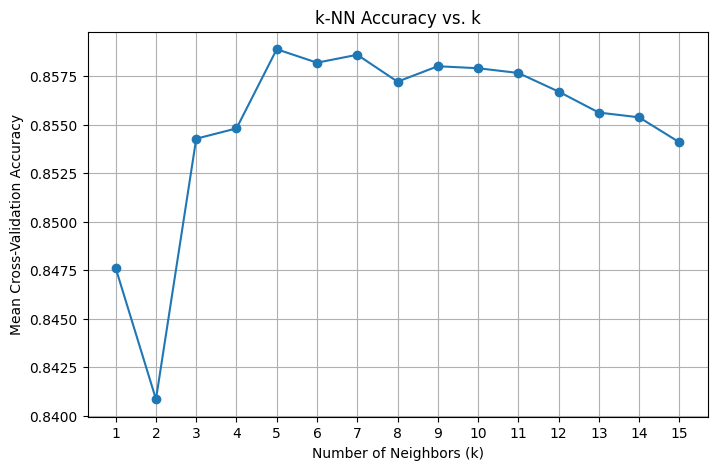


Best k based on cross-validation: 5


In [27]:
# Plot accuracy vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, mean_accuracies, marker='o', linestyle='-')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.title("k-NN Accuracy vs. k")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Best k value based on highest accuracy
best_k = k_values[np.argmax(mean_accuracies)]
print(f"\nBest k based on cross-validation: {best_k}")

In [28]:
# Train final KNN model using best k
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_pca, y_train)

# Evaluate on validation set
y_valid_pred = knn_model.predict(X_valid_pca)
knn_valid_accuracy = accuracy_score(y_valid, y_valid_pred)

print(f"KNN Validation Accuracy: {knn_valid_accuracy:.4f}")

KNN Validation Accuracy: 0.8605


In [56]:
# Evaluate on test set
y_test_pred_knn = knn_model.predict(X_test_pca)
knn_test_accuracy = accuracy_score(y_test, y_test_pred_knn)
print(f"KNN Test Accuracy: {knn_test_accuracy:.4f}")

KNN Test Accuracy: 0.8668


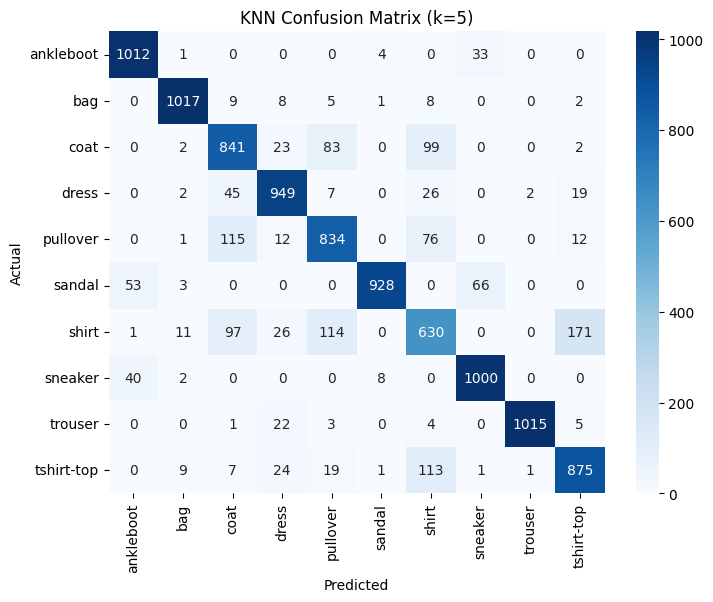

In [57]:
# Compute confusion matrix for KNN
cm = confusion_matrix(y_test, y_test_pred_knn)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"KNN Confusion Matrix (k={best_k})")
plt.show()

In [58]:
# Print classification report
print(f"KNN Classification Report (k={best_k}):")
print(classification_report(y_test, y_test_pred_knn))

KNN Classification Report (k=5):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1050
           1       0.97      0.97      0.97      1050
           2       0.75      0.80      0.78      1050
           3       0.89      0.90      0.90      1050
           4       0.78      0.79      0.79      1050
           5       0.99      0.88      0.93      1050
           6       0.66      0.60      0.63      1050
           7       0.91      0.95      0.93      1050
           8       1.00      0.97      0.98      1050
           9       0.81      0.83      0.82      1050

    accuracy                           0.87     10500
   macro avg       0.87      0.87      0.87     10500
weighted avg       0.87      0.87      0.87     10500



### Training and Evaluating Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
# Define K-Fold with shuffling
cv = KFold(n_splits=5, shuffle=True, random_state=student_id)

# Train Random Forest with cross-validation
rf_model = RandomForestClassifier(n_estimators=100, random_state=student_id)

# Perform 5-fold cross-validation
rf_scores = cross_val_score(rf_model, X_train_pca, y_train, cv=cv)

# Print performance for each fold
print("Random Forest Cross-Validation Results (5 folds):")
for fold_index, score in enumerate(rf_scores, start=1):
    print(f" Fold {fold_index} Accuracy: {score:.4f}")

# Print mean accuracy and standard deviation
print(f"\nMean Accuracy: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")

Random Forest Cross-Validation Results (5 folds):
 Fold 1 Accuracy: 0.8634
 Fold 2 Accuracy: 0.8658
 Fold 3 Accuracy: 0.8589
 Fold 4 Accuracy: 0.8662
 Fold 5 Accuracy: 0.8643

Mean Accuracy: 0.8637 ± 0.0026


In [37]:
# Train Random Forest on full PCA-transformed training set
rf_model.fit(X_train_pca, y_train)

# Evaluate on validation set
y_valid_pred = rf_model.predict(X_valid_pca)
rf_valid_accuracy = accuracy_score(y_valid, y_valid_pred)

print(f"Random Forest Validation Accuracy (PCA Applied): {rf_valid_accuracy:.4f}")


Random Forest Validation Accuracy (PCA Applied): 0.8636


In [59]:
# Evaluate on the test set (unseen data)
y_test_pred_random_forest = rf_model.predict(X_test_pca)
rf_test_accuracy = accuracy_score(y_test, y_test_pred_random_forest)

print(f"Random Forest Test Accuracy (PCA Applied): {rf_test_accuracy:.4f}")


Random Forest Test Accuracy (PCA Applied): 0.8649


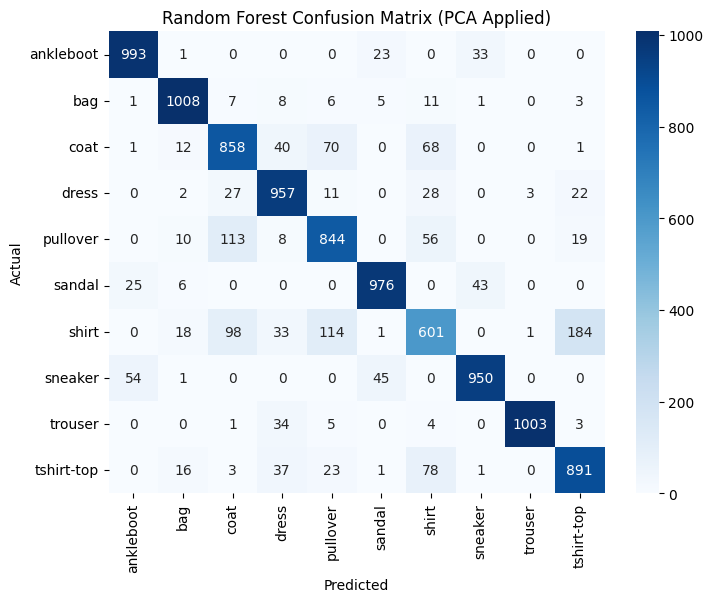

In [60]:
# Compute confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_test_pred_random_forest)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix (PCA Applied)")
plt.show()

In [61]:
# Print classification report for Random Forest
print("Random Forest Classification Report (PCA Applied):")
print(classification_report(y_test, y_test_pred_random_forest))

Random Forest Classification Report (PCA Applied):
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1050
           1       0.94      0.96      0.95      1050
           2       0.78      0.82      0.80      1050
           3       0.86      0.91      0.88      1050
           4       0.79      0.80      0.80      1050
           5       0.93      0.93      0.93      1050
           6       0.71      0.57      0.63      1050
           7       0.92      0.90      0.91      1050
           8       1.00      0.96      0.98      1050
           9       0.79      0.85      0.82      1050

    accuracy                           0.86     10500
   macro avg       0.86      0.86      0.86     10500
weighted avg       0.86      0.86      0.86     10500



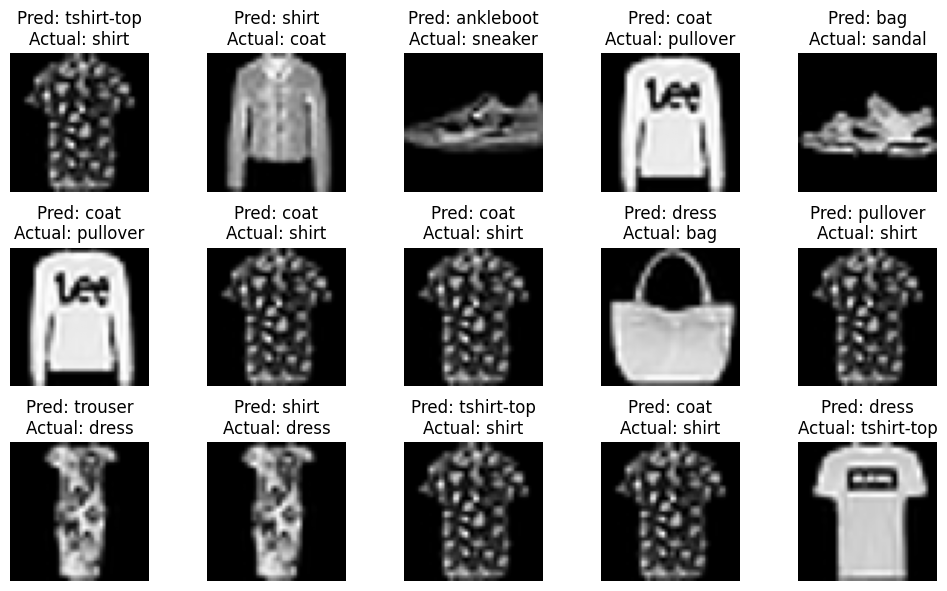

In [62]:
# Find misclassified indices
misclassified_idxs = np.where(y_test != y_test_pred_random_forest)[0]

# Display some misclassified images
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.ravel()

for i in range(min(15, len(misclassified_idxs))):
    idx = misclassified_idxs[i]

    # Retrieve original image (before PCA transformation)
    original_image = X[np.where(y == y_test[idx])[0][0]].reshape(image_size)

    axes[i].imshow(original_image, cmap="gray")
    axes[i].set_title(f"Pred: {categories[y_test_pred[idx]]}\nActual: {categories[y_test[idx]]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Ensure category names are dynamically retrieved from the dataset
categories = np.array(os.listdir(dataset_path))

# Get classification reports as dictionaries
report_svm = classification_report(y_test, y_test_pred_svm, output_dict=True)
report_knn = classification_report(y_test, y_test_pred_knn, output_dict=True)
report_rf = classification_report(y_test, y_test_pred_random_forest, output_dict=True)

# Extract recall values and round to whole numbers
misclassification_svm = [round((1 - report_svm[str(i)]['recall']) * 100) for i in range(len(categories))]
misclassification_knn = [round((1 - report_knn[str(i)]['recall']) * 100) for i in range(len(categories))]
misclassification_rf = [round((1 - report_rf[str(i)]['recall']) * 100) for i in range(len(categories))]

# Create a DataFrame for misclassification comparison
misclassification_df = pd.DataFrame({
    "Category": categories, 
    "SVM Misclassification (%)": misclassification_svm,
    "KNN Misclassification (%)": misclassification_knn,
    "Random Forest Misclassification (%)": misclassification_rf
})

# Display the updated table in Jupyter Notebook
misclassification_df


,Category,SVM Misclassification (%),KNN Misclassification (%),Random Forest Misclassification (%)
0,ankleboot,6,4,5
1,bag,5,3,4
2,coat,21,20,18
3,dress,9,10,9
4,pullover,24,21,20
5,sandal,7,12,7
6,shirt,42,40,43
7,sneaker,6,5,10
8,trouser,4,3,4
9,tshirt-top,17,17,15


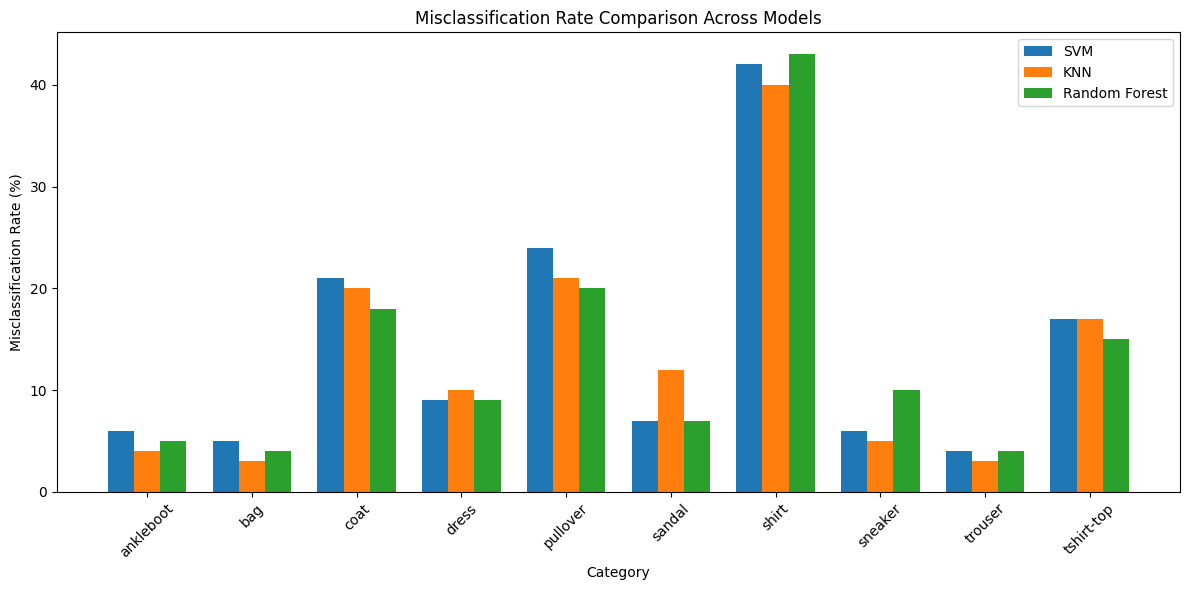

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure category names are dynamically retrieved from the dataset
categories = np.array(os.listdir(dataset_path))
categories = sorted(categories)

# Extract recall values (misclassification = 1 - recall) and round to whole numbers
misclassification_svm = np.array([round((1 - report_svm[str(i)]['recall']) * 100) for i in range(len(categories))])
misclassification_knn = np.array([round((1 - report_knn[str(i)]['recall']) * 100) for i in range(len(categories))])
misclassification_rf = np.array([round((1 - report_rf[str(i)]['recall']) * 100) for i in range(len(categories))])

# Define bar width
bar_width = 0.25
index = np.arange(len(categories))

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(index, misclassification_svm, bar_width, label="SVM")
plt.bar(index + bar_width, misclassification_knn, bar_width, label="KNN")
plt.bar(index + 2 * bar_width, misclassification_rf, bar_width, label="Random Forest")

# Labeling
plt.xlabel("Category")
plt.ylabel("Misclassification Rate (%)")
plt.title("Misclassification Rate Comparison Across Models")
plt.xticks(index + bar_width, categories, rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()
